<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Food%20and%20Bev%20Spending/Sarima%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sqlalchemy
!pip install pymysql
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.1 MB/s 
     |████████████████████████████████| 9.8 MB 36.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
from sqlalchemy import create_engine
from urllib.parse import quote
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='445'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

In [6]:
df = df[['ds', 'y']][df['ds'] > '2010-01-01']

In [7]:
df = df.set_index('ds')
df.index.freq = 'M'

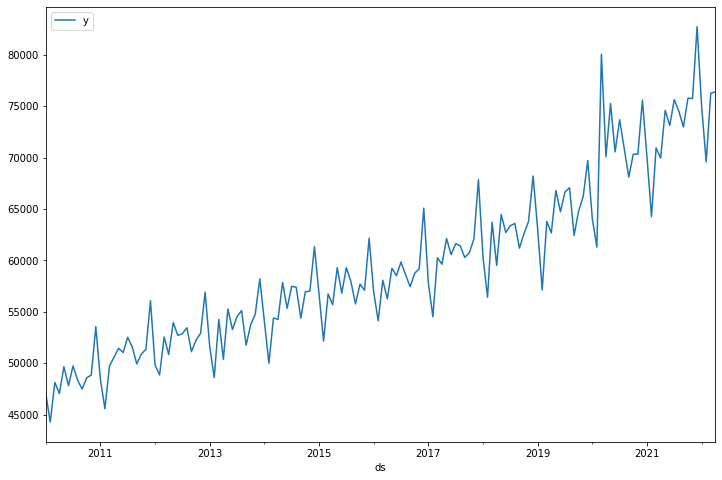

In [8]:
df.plot(figsize=(12,8))

In [9]:
res = seasonal_decompose(df, model='additive')

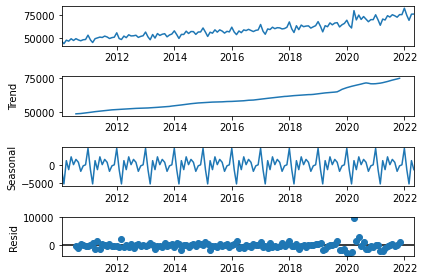

In [10]:
res.plot();

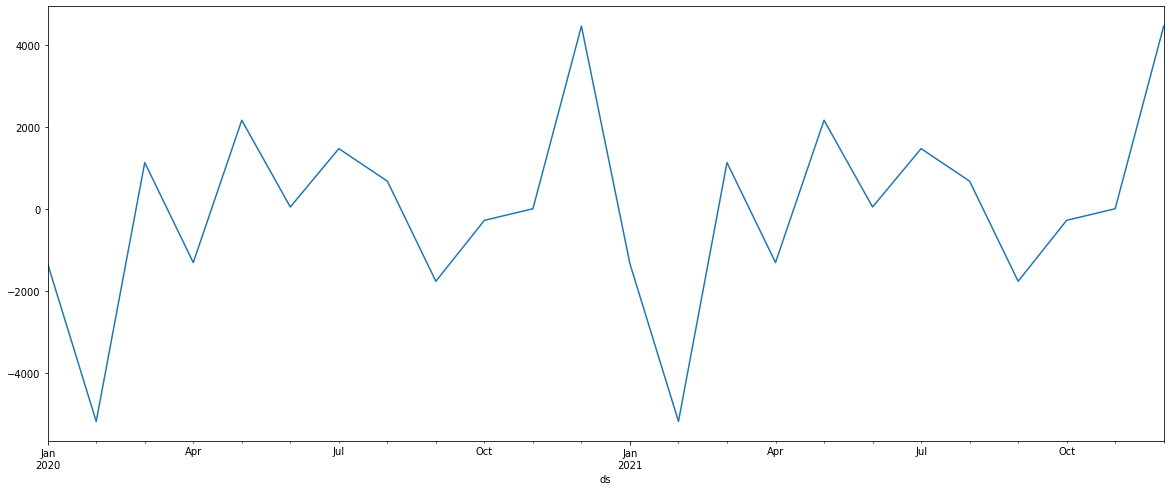

In [11]:
res.seasonal["2020":"2021"].plot(figsize=(20,8));

In [12]:
auto_arima(y=df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2847.367, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2800.106, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2803.955, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2845.767, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2828.595, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2796.408, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2797.369, Time=1.39 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2796.531, Time=0.60 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2811.369, Time=0.30 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=2795.239, Time=0.70 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2799.172, Time=0.21 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=2796.580, Time=3.99 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(3,1,0)(2,0,0)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  148
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1387.987
Date:                              Tue, 12 Jul 2022   AIC                           2783.973
Time:                                      09:43:21   BIC                           2795.935
Sample:                                           0   HQIC                          2788.833
                                              - 148                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1911      0.032     -5.896      0.000      -0.255      -0.128
ar.S.L12       0.8233      0.050     16.342      0.000       0.725       0.922
ma.S.L12      -0.6408      0.065     -9.913      0.000      -0.768      -0.514
sigma2      8.729e+06   2.62e-09   3.33e+15      0.000    8.73e+06    8.73e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.21   Jarque-Bera (JB):               293.85
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.46   Kurtosis:                         9.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.14e+30. Standard errors may be unstable.
"""

In [13]:
sxorder = (1,1,0)
sxsorder = (1,0,1,12)

In [14]:
def testmodel(train, test):
    print('train end: ', train.index[-1])
    
    print('\n---------\n')

    model = SARIMAX(endog=train, order=sxorder, seasonal_order=sxsorder).fit(disp=0)

    test['ypred'] = model.predict(start=test.index[0], end=test.index[-1])

    mape = round(np.mean(np.abs((test['y'] - test['ypred'])/test['y'])),3)
    accuracy = round((1-mape)*100,1)
    print('Accuracy: ', accuracy)

    print('\n---------\n')

    dffcast = model.get_forecast(steps=24).summary_frame()
    dffcast['bounds'] = round((pd.to_numeric(dffcast['mean_ci_upper'])-pd.to_numeric(dffcast['mean_ci_lower']))/pd.to_numeric(dffcast['mean'])*100)
    print(dffcast[['mean_ci_lower', 'mean', 'mean_ci_upper', 'bounds']])
    
    print('\n---------\n')
    
    test['mape'] = (1-round(abs(test['y'] - test['ypred'])/test['y'],6))*100
    test[['y', 'ypred', 'mape']]
    print(test[['y', 'ypred', 'mape']])

In [15]:
testmodel(df[:-48], df[-48:])

train end:  2018-04-30 00:00:00

---------

Accuracy:  88.5

---------

y           mean_ci_lower          mean  mean_ci_upper  bounds
2018-05-31   55186.990552  60901.387597   66615.784641    19.0
2018-06-30   52891.272821  60387.664555   67884.056288    25.0
2018-07-31   51778.555414  60779.525226   69780.495038    30.0
2018-08-31   50341.777746  60620.088497   70898.399248    34.0
2018-09-30   48800.462672  60215.335435   71630.208197    38.0
2018-10-31   48050.830629  60498.743108   72946.655587    41.0
2018-11-30   47316.806830  60718.388847   74119.970865    44.0
2018-12-31   47974.954329  62266.706314   76558.458298    46.0
2019-01-31   45229.299605  60358.938094   75488.576584    50.0
2019-02-28   43416.644680  59340.141287   75263.637894    54.0
2019-03-31   44404.629078  61084.243219   77763.857360    55.0
2019-04-30   42922.273732  60325.184740   77728.095747    58.0
2019-05-31   42562.566454  60909.822079   79257.077705    60.0
2019-06-30   41426.415591  60633.601443   7984

In [16]:
model = SARIMAX(endog=df, order=sxorder, seasonal_order=sxsorder).fit(disp=0)
pred = model.get_forecast(steps=51).summary_frame()

In [17]:
dffin = pd.DataFrame(index=pd.date_range(df.index[0], pred.index[-1], freq='M'))

In [18]:
dffin['y'] = df['y']
dffin['ypred'] = pred['mean']

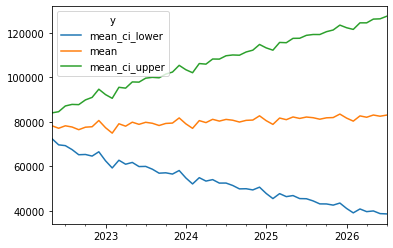

In [19]:
pred[['mean_ci_lower', 'mean', 'mean_ci_upper']].plot()

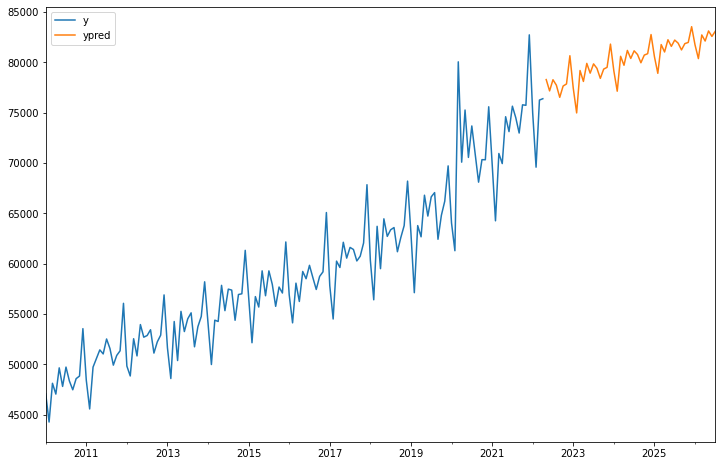

In [20]:
dffin.plot(figsize=(12,8))

In [21]:
pred

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-05-31,78287.046193,2954.495217,72496.341975,84077.750411
2022-06-30,77162.347639,3800.173515,69714.144415,84610.550863
2022-07-31,78271.716670,4547.604722,69358.575199,87184.858142
2022-08-31,77734.861139,5178.570847,67585.048788,87884.673490
2022-09-30,76524.679708,5742.299271,65269.979949,87779.379467
2022-10-31,77646.239485,6255.131859,65386.406323,89906.072647
2022-11-30,77853.108744,6729.046068,64664.420800,91041.796689
2022-12-31,80655.857290,7171.702099,66599.579468,94712.135112
2023-01-31,77426.386271,7588.582256,62553.038356,92299.734187
2023-02-28,74975.783779,7983.723731,59327.972803,90623.594755


In [22]:
pred = pred[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred.columns = ['Projection', 'Lower Bound', 'Upper Bound']
pred.to_excel('Drugstore Projected MarketSize - USCensus.xlsx')